### Predicting the number of problems per km2

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from pycircular.utils import freq_time, date2rad
from pycircular.plots import base_periodic_fig
import vonMisesMixtures as vonmises

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score 

import shap

In [174]:
SMALL_SIZE = 8 # points
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams['figure.facecolor']   = 'white'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.facecolor']     = 'white'
plt.rcParams['axes.spines.right']  = False
plt.rcParams['axes.spines.top']    = False
plt.rcParams['font.family']        = 'sans-serif'
plt.rcParams['font.sans-serif']    = ['Arial', 'DejaVu']
plt.rcParams['savefig.dpi']        = 300
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['ps.fonttype']        = 42

cm = 1/2.54  # centimeters in inches
single_col = 8.9*cm
oneDot5_col = 12.7*cm
two_col = 18.2*cm

In [218]:
input_folder  = './processed_db'
output_folder = './files_ML_problemsPerKm2_circular'

In [219]:
df = pd.read_csv('{}/db_criminalBehaviour_TimeRegional.csv'.format(input_folder))
df.drop(['categories', 'Unnamed: 0'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               4369 non-null   int64  
 1   hour_rads          4369 non-null   float64
 2   regional_name      4369 non-null   object 
 3   problem_type_1     4369 non-null   object 
 4   count              4369 non-null   int64  
 5   nProb_km2          4317 non-null   float64
 6   avg_monthlyIncome  4317 non-null   float64
 7   pop_km2            4317 non-null   float64
 8   people_house       4317 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 307.3+ KB


In [220]:
df.dropna(how='any', inplace=True)

In [221]:
df.describe()

,time,hour_rads,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,12.792448,3.327466,20.851054,0.551123,1439.989576,4058.527913,3.310892
std,6.456456,1.656507,58.770645,1.629594,725.830531,1523.685147,0.564748
min,0.000000,0.000000,1.000000,0.015601,518.000000,1126.000000,2.580000
25%,8.000000,2.094395,1.000000,0.028329,870.000000,2775.000000,2.770000
50%,13.000000,3.403392,4.000000,0.100503,1384.000000,3942.000000,3.420000
75%,18.000000,4.712389,19.000000,0.468019,1612.000000,5573.000000,3.630000
max,23.000000,6.021386,1283.000000,35.344353,2897.000000,6193.000000,4.550000


In [222]:
df.problem_type_1.unique()

array(['Agression', 'Break-in', 'Corporal injury', 'Environmental crime',
       'Gang-sacking/pillaging', 'Gunshot', 'Illegal possession',
       'Illitcit Substance', 'Kidnapping and imprisonment', 'Murder',
       'Non-compliance with law 15799/2021 COVID-19',
       'Obscene/libelous acts', 'Physical/Verbal Agression', 'Racism',
       'Robbery', 'Theft',
       'Violation of Protective Measures for women - Lei Maria da Penha',
       'Fishing in Prohibited Places', 'Maltreatment', 'Rape',
       'Sexual harassment',
       'Abandonment/nonsupport of incompetent person',
       'Crime against individual liberty', 'Embezzlement', 'Homophobia',
       'Prohibited sale of specific products to minors',
       'Possession of explosive device', 'False Identity',
       'Fraud (monetary)', 'Impersonating a public official',
       'Violation of graves', 'Animal abuse', 'Misuse of transport card',
       'Child grooming/enticement', 'Omission of assistance',
       'False money', 'Abuse of

In [223]:
problems2keep = [
    'Agression', 'Break-in', 'Corporal injury', 'Environmental crime',
       'Gang-sacking/pillaging', 'Gunshot', 'Illegal possession',
       'Illitcit Substance', 'Kidnapping and imprisonment', 'Murder',
       'Non-compliance with law 15799/2021 COVID-19',
       'Physical/Verbal Agression', 'Racism',
       'Robbery', 'Theft',
       'Violation of Protective Measures for women - Lei Maria da Penha',
       'Rape',
       'Sexual harassment',
       'Abandonment/nonsupport of incompetent person',
       'Crime against individual liberty', 'Embezzlement', 'Homophobia',
       'Prohibited sale of specific products to minors',
       'Possession of explosive device', 'False Identity',
       'Fraud (monetary)', 'Impersonating a public official',
       'Violation of graves', 
       'Child grooming/enticement', 'Omission of assistance',
       'False money', 'Abuse of incapacitated persons',
       'Theft, loss, recovery, seizure of firearms',
       'Sexual assault/rape', 'Extortion',
       'Corruption of minors', 'Prostitution', 'Crime against corpses',
       'Exploitation of minors', 'Discrimination',
       'Favouring prostitution', 'Smuggling/contraband', 'Corruption',
       'Irregular landfill', 'Arbitrary violence',
       'Concussion (corruption)', 'Gambling',
       'Refuse to indentify yourself to the police',
       'Wearing a uniform, or badge of a public function that he does not exercise',
       'Gang', 'Quackery', 'Supplying alcohol to minors',
       'Incitement to crime', 'Crime apology', 'Defamation', 'Stalking',
       'Obstruction of Police Activity',
       'Falsification of Public Document',
       'Procuring/Pimping (prostitution)', 'Prevarication (corruption)'
]

In [278]:
problems2vis = [
    'Agression', 
       'Gunshot', 'Robbery', 
       'Kidnapping and imprisonment', 'Murder', 
       'Impersonating a public official', 'Rape',
       'Omission of assistance','Exploitation of minors',
]

In [225]:
df = df[df['problem_type_1'].isin(problems2keep)]
df.reset_index(inplace=True)
df.drop('index', axis=1,inplace=True)

In [226]:
df['sin_hour'] = np.sin(df['hour_rads'])
df['cos_hour'] = np.cos(df['hour_rads'])

Dataframe not modified from here 

In [227]:
df

,time,hour_rads,regional_name,problem_type_1,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house,sin_hour,cos_hour
0,0,1.570796,BAIRRO NOVO,Agression,9,0.200893,870.0,2775.0,2.65,1.000000,6.123234e-17
1,0,1.570796,BAIRRO NOVO,Break-in,65,1.450893,870.0,2775.0,2.65,1.000000,6.123234e-17
2,0,1.570796,BAIRRO NOVO,Corporal injury,13,0.290179,870.0,2775.0,2.65,1.000000,6.123234e-17
3,0,1.570796,BAIRRO NOVO,Environmental crime,1,0.022321,870.0,2775.0,2.65,1.000000,6.123234e-17
4,0,1.570796,BAIRRO NOVO,Gang-sacking/pillaging,1,0.022321,870.0,2775.0,2.65,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...
3647,23,1.832596,TATUQUARA,Non-compliance with law 15799/2021 COVID-19,1,0.024390,518.0,1126.0,3.81,0.965926,-2.588190e-01
3648,23,1.832596,TATUQUARA,Physical/Verbal Agression,18,0.439024,518.0,1126.0,3.81,0.965926,-2.588190e-01
3649,23,1.832596,TATUQUARA,Robbery,5,0.121951,518.0,1126.0,3.81,0.965926,-2.588190e-01
3650,23,1.832596,TATUQUARA,Theft,5,0.121951,518.0,1126.0,3.81,0.965926,-2.588190e-01


Plots

In [228]:
num_features = ['time','nProb_km2','avg_monthlyIncome','pop_km2','people_house']

In [229]:
df[num_features].corr('pearson')

,time,nProb_km2,avg_monthlyIncome,pop_km2,people_house
time,1.000000,0.088210,0.005331,0.018340,0.018539
nProb_km2,0.088210,1.000000,0.181185,0.147419,-0.136199
avg_monthlyIncome,0.005331,0.181185,1.000000,0.583195,-0.256270
pop_km2,0.018340,0.147419,0.583195,1.000000,-0.046737
people_house,0.018539,-0.136199,-0.256270,-0.046737,1.000000


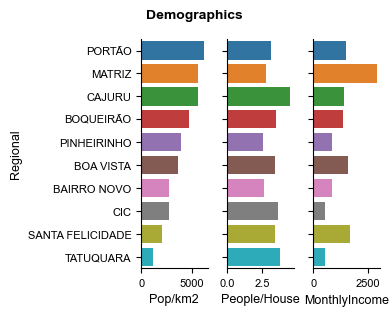

In [313]:
demo_feat = ['pop_km2', 'people_house', 'avg_monthlyIncome']
sorted_data = df.sort_values(['pop_km2', 'people_house', 'avg_monthlyIncome'], ascending=False)

plt.figure(figsize=(10*cm, 8*cm))
plt.suptitle('Demographics')
ax1 = plt.subplot(1,3,1)
sns.barplot(data=sorted_data, y='regional_name', x=demo_feat[0], orient='h')
plt.ylabel('Regional')
plt.xlabel('Pop/km2')
ax2 = plt.subplot(1,3,2,sharey=ax1)
plt.tick_params('y', labelleft=False)
sns.barplot(data=sorted_data, y='regional_name', x=demo_feat[1], orient='h')
plt.ylabel('')
plt.xlabel('People/House')
ax3 = plt.subplot(1,3,3,sharey=ax1)
sns.barplot(data=sorted_data, y='regional_name', x=demo_feat[2], orient='h')
plt.tick_params('y', labelleft=False)
plt.ylabel('')
plt.xlabel('MonthlyIncome')
plt.tight_layout()

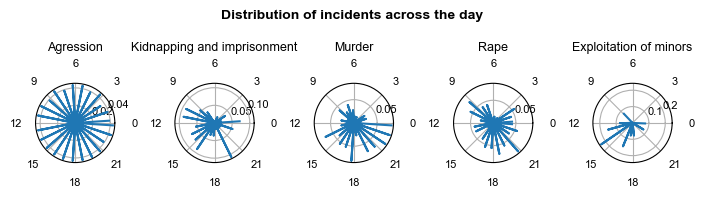

In [327]:
problems2vis = [
    'Agression', 
    #    'Gunshot', 'Robbery', 
       'Kidnapping and imprisonment', 'Murder', 
    #    'Impersonating a public official', 
       'Rape',
    #    'Omission of assistance',
       'Exploitation of minors',
]

number_of_bins = 48

idxPlot = 1
plt.figure(figsize=(18*cm, 5*cm))
plt.suptitle('Distribution of incidents across the day')
for prob in problems2vis:
    dt2plot = df[(df['problem_type_1']==prob)].copy()
    
    dt2plot["hour_rads"] = dt2plot["time"] * (2.0 * np.pi / dt2plot["time"].max())
    dt2plot = dt2plot.sort_values('time')
    # print(dt2plot[['hour', 'hour_rads']])

    x_histo = vonmises.tools.histogram(dt2plot['hour_rads'],bins=number_of_bins)

    # ax = plt.subplot(3,3,idxPlot, projection='polar')
    ax = plt.subplot(1,5,idxPlot, projection='polar')
    plt.plot(x_histo[0], x_histo[1])
    plt.title(prob)
    plt.xticks(ax.get_xticks(), labels=np.arange(0,24,step=3)) 
    # plt.ylim([0,0.17])
    # plt.yticks(np.arange(0,0.17, step=0.05))
    idxPlot += 1

plt.tight_layout()

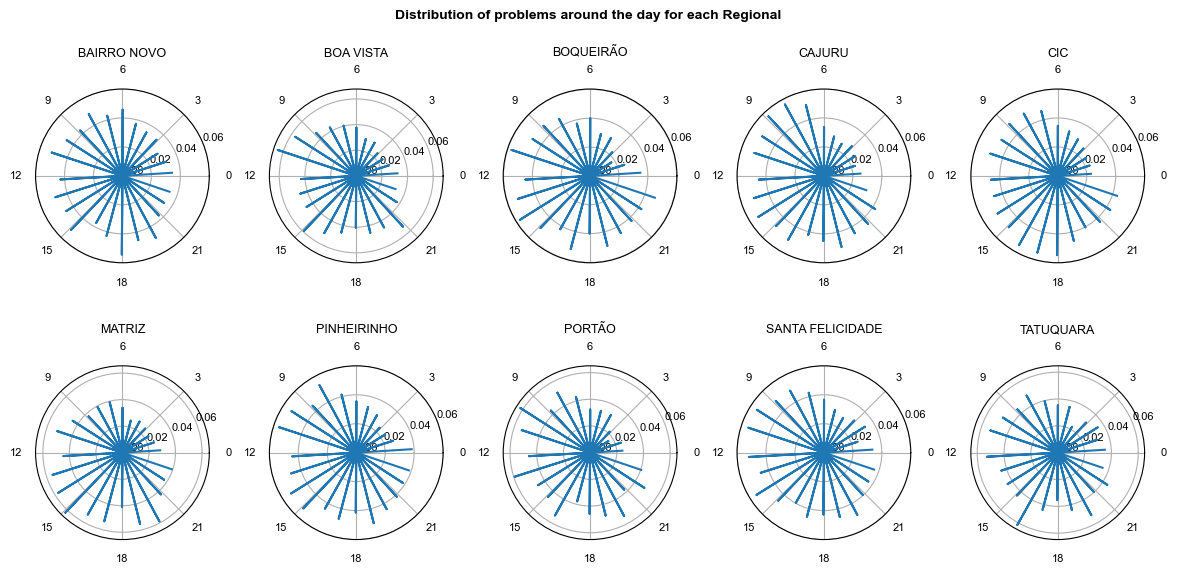

In [284]:
number_of_bins = 48

idxPlot = 1
plt.figure(figsize=(30*cm, 15*cm))
plt.suptitle('Distribution of problems around the day for each Regional')
for reg in df.regional_name.unique():
    dt2plot = df[(df['regional_name']==reg)]
    
    x_histo = vonmises.tools.histogram(dt2plot['hour_rads'],bins=number_of_bins)

    ax = plt.subplot(2,5,idxPlot, projection='polar')
    plt.plot(x_histo[0], x_histo[1])
    plt.title(reg)
    plt.xticks(ax.get_xticks(), labels=np.arange(0,24,step=3)) 
    # plt.ylim([0,0.17])
    plt.yticks(np.arange(0,0.07, step=0.02))
    idxPlot += 1

plt.tight_layout()

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


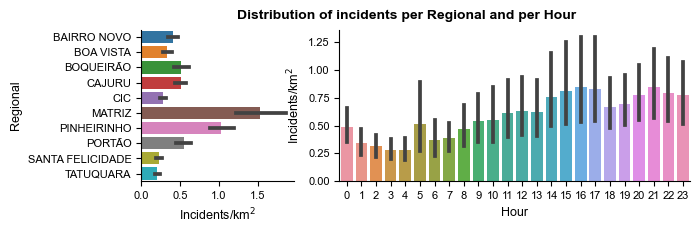

In [322]:
plt.figure(figsize=(18*cm, 5*cm))
plt.suptitle('Distribution of incidents per Regional and per Hour')
grid = plt.GridSpec(1, 3, wspace =0.3, hspace = 0.3)
plt.subplot(grid[0, 0])
sns.barplot(data=df, y='regional_name', x='nProb_km2', orient='h')
plt.ylabel('Regional')
plt.xlabel('Incidents/km$^2$')

plt.subplot(grid[0, 1:])
sns.barplot(data=df, x='time', y='nProb_km2')
plt.ylabel('Incidents/km$^2$')
plt.xlabel('Hour')

plt.tight_layout()

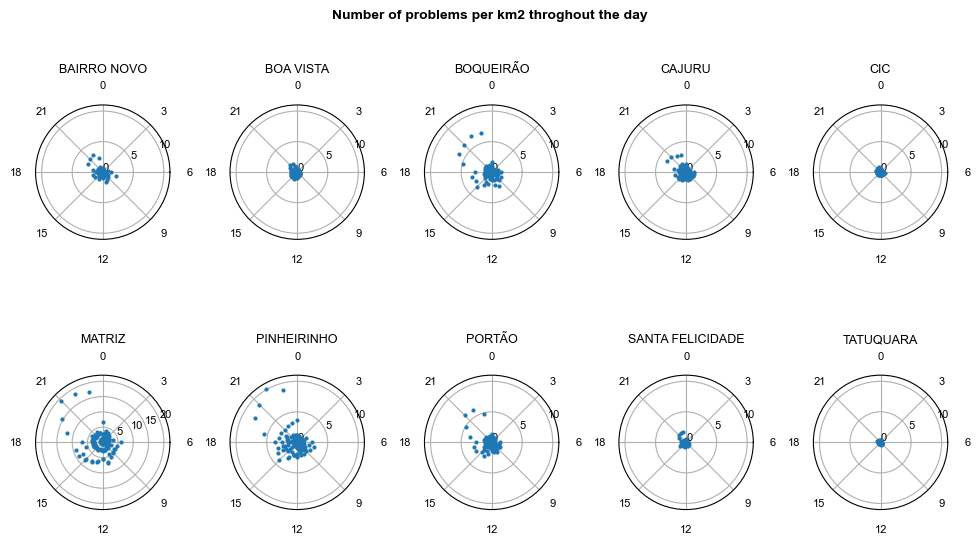

In [57]:
idxPlot = 1
plt.figure(figsize=(25*cm, 15*cm))
plt.suptitle('Number of problems per km2 throghout the day')
for reg in df.regional_name.unique():
    dt2plot = df[(df['regional_name']==reg)]

    ax = plt.subplot(2,5,idxPlot, projection='polar')
    plt.plot(dt2plot['hour_rads'], dt2plot['nProb_km2'], marker='o', linestyle='', markersize=2)
    plt.title(reg)
    plt.xticks(ax.get_xticks(), labels=np.roll(np.flip(np.arange(0,24,step=3)),3)) 
    if reg == 'MATRIZ':
        plt.yticks(np.arange(0,22, step=5))
        plt.ylim([0,22])
    else:
        plt.yticks(np.arange(0,22, step=5))
        plt.ylim([0,11])
    idxPlot += 1
plt.tight_layout()

Defining a test set:

In [230]:
y = np.array(list(df.nProb_km2))
X = df.drop(['count', 'nProb_km2', 'regional_name', 'time', 'hour_rads'], axis=1)

In [231]:
y

array([0.20089286, 1.45089288, 0.29017858, ..., 0.12195122, 0.12195122,
       0.36585366])

In [232]:
X

,problem_type_1,avg_monthlyIncome,pop_km2,people_house,sin_hour,cos_hour
0,Agression,870.0,2775.0,2.65,1.000000,6.123234e-17
1,Break-in,870.0,2775.0,2.65,1.000000,6.123234e-17
2,Corporal injury,870.0,2775.0,2.65,1.000000,6.123234e-17
3,Environmental crime,870.0,2775.0,2.65,1.000000,6.123234e-17
4,Gang-sacking/pillaging,870.0,2775.0,2.65,1.000000,6.123234e-17
...,...,...,...,...,...,...
3647,Non-compliance with law 15799/2021 COVID-19,518.0,1126.0,3.81,0.965926,-2.588190e-01
3648,Physical/Verbal Agression,518.0,1126.0,3.81,0.965926,-2.588190e-01
3649,Robbery,518.0,1126.0,3.81,0.965926,-2.588190e-01
3650,Theft,518.0,1126.0,3.81,0.965926,-2.588190e-01


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dummy Regressor for baseline comparison:

In [234]:
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred = dummy_regr.predict(y_test)
dummy_regr.score(X_train, y_train)

0.0

In [235]:
r2_score(y_test,y_pred)

-0.0005630735476018778

Well, any model is going to be better than this...

Creating a pipeline and doing the grid-search for a list of selected models:

In [236]:
num_features = ['avg_monthlyIncome', 'pop_km2', 'people_house']
# cat_features = ['regional_name', 'problem_type_1']
cat_features = ['problem_type_1']

In [237]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)],
        remainder='passthrough')

In [238]:
models2test = {
    'SVR' : SVR(),   
    'DTree': DecisionTreeRegressor(random_state=4392),
    # 'ExtraTree': ExtraTreesRegressor(random_state=4392),
    'GradBoost': GradientBoostingRegressor(random_state=4392),
}

In [239]:
param2test = {
    'SVR' : {
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    },   
    'DTree': {
        'classifier__max_depth' : [2, 4, 6, 8, 10],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'ExtraTree': {
        'classifier__n_estimators': [10, 100, 500],
        'classifier__max_depth' : [2, 4, 6, 8, 10],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'GradBoost': {
        'classifier__max_depth' : [2, 4, 6, 8, 10],
        'classifier__n_estimators': [10, 100, 500],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
}

In [240]:
search = dict()
for clf in models2test.keys():
    print(clf)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models2test[clf])
    ])
    param_grid = param2test[clf]
    search = GridSearchCV(pipeline, param_grid, cv=5).fit(X_train,y_train)
    # joblib.dump(search, '{}/paramTuning_{}.pkl'.format(output_folder, clf))
    joblib.dump(search, '{}/paramTuning_wholeDB_{}.pkl'.format(output_folder, clf))

SVR
DTree
GradBoost


Loading grid search results

In [241]:
bestParams = dict()
bestScores = dict()
bestModels  = dict()
yPred_train = dict()
yPred_test = dict()
for clf in models2test.keys():
    # tmp_load = joblib.load('{}/paramTuning_{}.pkl'.format(output_folder, clf))
    tmp_load = joblib.load('{}/paramTuning_wholeDB_{}.pkl'.format(output_folder, clf))
    yPred_train[clf] = tmp_load.predict(X_train)
    yPred_test[clf]  = tmp_load.predict(X_test)

    bestParams[clf] = tmp_load.best_params_
    bestScores[clf] = tmp_load.best_score_
    bestModels[clf] = tmp_load.best_estimator_

    joblib.dump(search, '{}/yPred_train_wholeDB_{}.pkl'.format(output_folder, clf))
    joblib.dump(search, '{}/yPred_test_wholeDB_{}.pkl'.format(output_folder, clf))



In [242]:
bestParams

{'SVR': {'classifier__C': 100, 'classifier__kernel': 'rbf'},
 'DTree': {'classifier__criterion': 'poisson', 'classifier__max_depth': 10},
 'GradBoost': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 6,
  'classifier__n_estimators': 500}}

In [243]:
bestScores

{'SVR': 0.8764095338299149,
 'DTree': 0.9048701847861148,
 'GradBoost': 0.9262908856937386}

In [244]:
for clf in models2test.keys():
    print(clf, "r2 train:", r2_score(y_train,yPred_train[clf]))
    print(clf, "r2 test:", r2_score(y_test,yPred_test[clf]))


SVR r2 train: 0.9110613268510859
SVR r2 test: 0.8284674579763203
DTree r2 train: 0.9952018696883767
DTree r2 test: 0.9466713322754505
GradBoost r2 train: 0.9989953310732289
GradBoost r2 test: 0.9465520561742861


- Gradient Boosting and Decision tree have similar performances, and smaller differences between train and test set scores (less chance of overfitting)

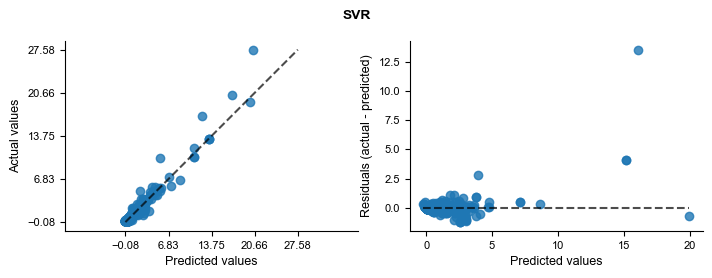

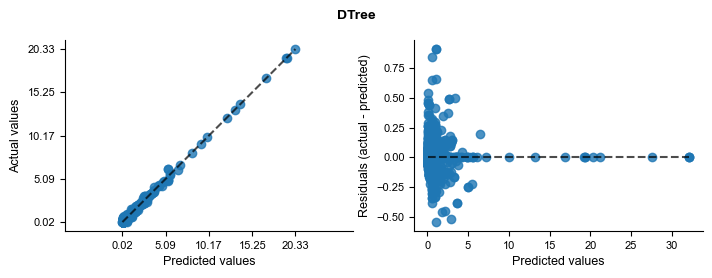

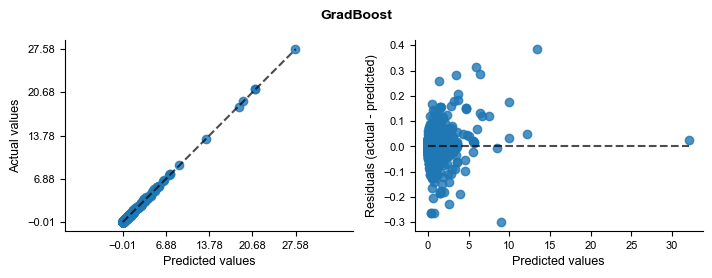

In [245]:
for clf in models2test.keys():
    fig, axs = plt.subplots(ncols=2, figsize=(two_col,7*cm))
    plt.suptitle(clf)
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=yPred_train[clf],
                                        kind="actual_vs_predicted", ax=axs[0])
    PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=yPred_train[clf],
                                        kind="residual_vs_predicted", ax=axs[1])
    plt.tight_layout()

- Decision tree and Gradient Boosting have similar residuals levels, SVR has higher residuals

Now let's check in the true test set (not the validation ones):

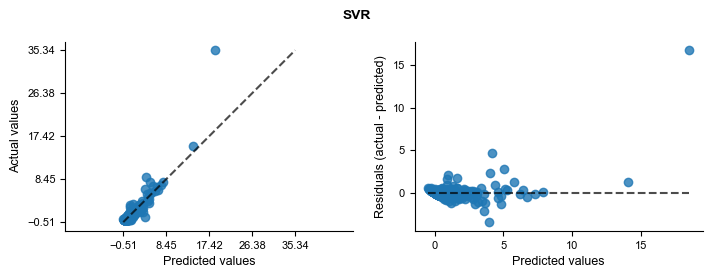

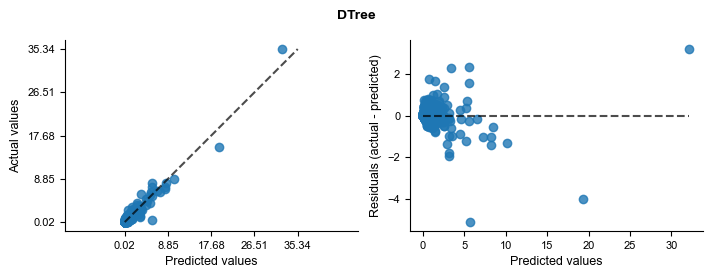

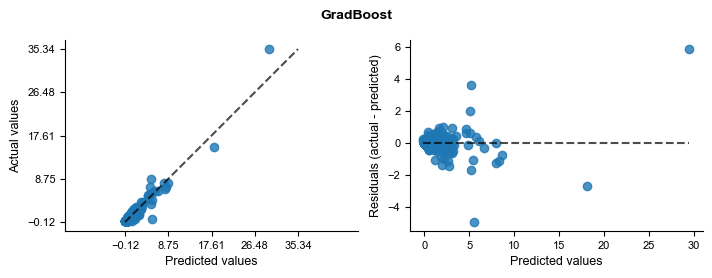

In [246]:
for clf in models2test.keys():
    fig, axs = plt.subplots(ncols=2, figsize=(two_col,7*cm))
    plt.suptitle(clf)
    PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=yPred_test[clf],
                                        kind="actual_vs_predicted", ax=axs[0])
    PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=yPred_test[clf],
                                        kind="residual_vs_predicted", ax=axs[1])
    plt.tight_layout()

- In the test set, residual levels seem to increase for predicted values above 4~5
- SVR seems to be the worse for high values
- Not much difference between Decision Tree and Gradient Boosting

Let's check the feature importance for the Gradient Boosting using the SHAP lib

In [247]:
preproc = preprocessor.fit(X_train)
X_train_pr = preproc.transform(X_train)
X_test_pr  = preproc.transform(X_test)

In [248]:
feat_names = preproc.get_feature_names_out()
feat_names = [x.split('__')[1] for x in feat_names]
feat_names = [x.split('_')[-1] if 'prob' in x else x for x in feat_names]
feat_names

['avg_monthlyIncome',
 'pop_km2',
 'people_house',
 'Abandonment/nonsupport of incompetent person',
 'Abuse of incapacitated persons',
 'Agression',
 'Arbitrary violence',
 'Break-in',
 'Child grooming/enticement',
 'Concussion (corruption)',
 'Corporal injury',
 'Corruption',
 'Corruption of minors',
 'Crime against corpses',
 'Crime against individual liberty',
 'Crime apology',
 'Defamation',
 'Discrimination',
 'Embezzlement',
 'Environmental crime',
 'Exploitation of minors',
 'Extortion',
 'False Identity',
 'False money',
 'Falsification of Public Document',
 'Favouring prostitution',
 'Fraud (monetary)',
 'Gambling',
 'Gang',
 'Gang-sacking/pillaging',
 'Gunshot',
 'Homophobia',
 'Illegal possession',
 'Illitcit Substance',
 'Impersonating a public official',
 'Incitement to crime',
 'Irregular landfill',
 'Kidnapping and imprisonment',
 'Murder',
 'Non-compliance with law 15799/2021 COVID-19',
 'Obstruction of Police Activity',
 'Omission of assistance',
 'Physical/Verbal Agre

In [249]:
feat_names[-3] = 'Wear uniform of function not exercised'
feat_names[-5] = 'Violation Lei Ma. da Penha'

In [250]:
X_train_pr = pd.DataFrame(X_train_pr.toarray(), columns=feat_names)
X_test_pr  = pd.DataFrame(X_test_pr.toarray(), columns=feat_names)

In [251]:
shap.initjs()

In [252]:
X_train_summary = shap.kmeans(X_train_pr, 10)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [253]:
ex = shap.KernelExplainer(bestModels['SVR'][-1].predict, X_train_summary)

  0%|          | 0/731 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


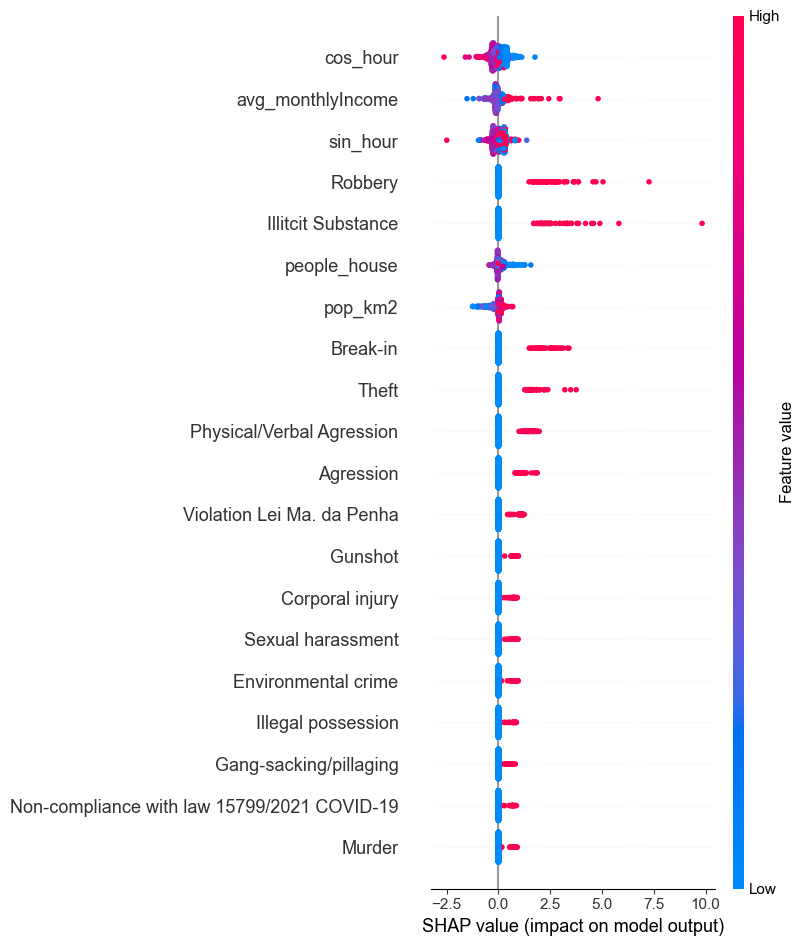

In [254]:
shap_values = ex.shap_values(X_test_pr)
shap.summary_plot(shap_values, X_test_pr)

In [255]:
print(y_test[78])
shap.force_plot(ex.expected_value, shap_values[78,:], X_test_pr.loc[78,:])


6.749311436620275


In [256]:
print(y_test[10])
shap.force_plot(ex.expected_value, shap_values[10,:], X_test_pr.loc[10,:])

0.0275482099453888


In [260]:
print(y_test[634])
shap.force_plot(ex.expected_value, shap_values[634,:], X_test_pr.loc[634,:])

1.6834171176971189


In [267]:
print(y_test[406])
shap.force_plot(ex.expected_value, shap_values[406,:], X_test_pr.loc[406,:])

0.4683195690716109


In [269]:
print(y_test[30])
shap.force_plot(ex.expected_value, shap_values[30,:], X_test_pr.loc[30,:])

0.4634146341463415


In [265]:
X_test2 = X_test.reset_index()

In [266]:
X_test2[X_test2.problem_type_1 == 'Violation of Protective Measures for women - Lei Maria da Penha']

,index,problem_type_1,avg_monthlyIncome,pop_km2,people_house,sin_hour,cos_hour
16,2972,Violation of Protective Measures for women - L...,518.0,1126.0,3.81,2.588190e-01,-9.659258e-01
30,1537,Violation of Protective Measures for women - L...,518.0,1126.0,3.81,-9.659258e-01,2.588190e-01
39,2713,Violation of Protective Measures for women - L...,2897.0,5573.0,2.77,1.224647e-16,-1.000000e+00
44,2543,Violation of Protective Measures for women - L...,2897.0,5573.0,2.77,-2.588190e-01,-9.659258e-01
61,2379,Violation of Protective Measures for women - L...,842.0,3942.0,2.58,-5.000000e-01,-8.660254e-01
88,279,Violation of Protective Measures for women - L...,1338.0,4728.0,3.50,8.660254e-01,5.000000e-01
96,534,Violation of Protective Measures for women - L...,518.0,1126.0,3.81,5.000000e-01,8.660254e-01
98,871,Violation of Protective Measures for women - L...,1681.0,2025.0,3.45,-2.588190e-01,9.659258e-01
117,809,Violation of Protective Measures for women - L...,523.0,2698.0,3.63,-2.588190e-01,9.659258e-01
127,298,Violation of Protective Measures for women - L...,523.0,2698.0,3.63,8.660254e-01,5.000000e-01
